In [1]:
import re
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, RepeatVector, TimeDistributed

In [2]:
with open("all_individual_data.txt", 'r') as file:
    all_dataset = [line.strip() for line in file]

# Use only the first half of the dataset
dataset = all_dataset[:len(all_dataset) // 5]

# Verify the size of the reduced dataset
print(f"Original dataset size: {len(all_dataset)}")
print(f"Half dataset size: {len(dataset)}")
print(dataset[:5])

Original dataset size: 1000000
Half dataset size: 200000
['prog2(prog2(swapAD, prog2(incI, clrI)), movGteA)', 'prog2(prog2(whileLoop(whileLoop(clrI)), whileLoop(prog2(readArrayD, movGteA))), whileLoop(whileLoop(prog2(incI, movGteA))))', 'prog2(movBmaxIter, movBmaxIter)', 'whileLoop(clrI)', 'prog2(clrI, readArrayD)']


In [3]:
# Tokenizer function
def tokenize_sequence(sequence):
    # Split on parentheses, commas, and identifiers
    tokens = re.findall(r'[a-zA-Z_][a-zA-Z0-9_]*|\d+|[(),]', sequence)
    return tokens


# Tokenize the dataset
tokenized_dataset = [tokenize_sequence(seq) for seq in dataset]

# Build vocabulary
all_tokens = [token for seq in tokenized_dataset for token in seq]
vocab = {token: idx + 2 for idx, token in enumerate(set(all_tokens))}
vocab['<PAD>'] = 0  # Padding token
vocab['<UNK>'] = 1  # Unknown token
vocab_size = len(vocab)

# Encode sequences to numerical format
encoded_dataset = [
    [vocab.get(token, vocab['<UNK>']) for token in seq]
    for seq in tokenized_dataset
]

# Pad sequences
max_length = max(len(seq) for seq in encoded_dataset)
padded_dataset = pad_sequences(encoded_dataset, maxlen=max_length, padding='post', value=vocab['<PAD>'])

# Split into training and validation sets
x_train = np.array(padded_dataset[:int(0.8 * len(padded_dataset))])
x_val = np.array(padded_dataset[int(0.8 * len(padded_dataset)):])

x_train_target = np.expand_dims(x_train, -1)  # Add dimension for sparse_categorical_crossentropy
x_val_target = np.expand_dims(x_val, -1)

In [4]:
example_sequence = "prog2(prog2(swapAD, prog2(incI, clrI)), movGteA)"
tokens = tokenize_sequence(example_sequence)

print("Original Sequence:", example_sequence)
print("Tokens:", tokens)


Original Sequence: prog2(prog2(swapAD, prog2(incI, clrI)), movGteA)
Tokens: ['prog2', '(', 'prog2', '(', 'swapAD', ',', 'prog2', '(', 'incI', ',', 'clrI', ')', ')', ',', 'movGteA', ')']


In [5]:
print("Vocabulary Sample:", dict(list(vocab.items())[:10]))
print("Vocabulary Size:", vocab_size)

Vocabulary Sample: {'incI': 2, '(': 3, 'swapAD': 4, 'movGteA': 5, 'prog2': 6, ',': 7, 'clrI': 8, 'readArrayD': 9, ')': 10, 'movBmaxIter': 11}
Vocabulary Size: 13


In [6]:
example_index = 0 
print("Original Sequence Length:", len(encoded_dataset[example_index]))
print("Padded Sequence Length:", len(padded_dataset[example_index]))
print("Padded Sequence:", padded_dataset[example_index])

Original Sequence Length: 16
Padded Sequence Length: 365
Padded Sequence: [ 6  3  6  3  4  7  6  3  2  7  8 10 10  7  5 10  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [15]:
# ---------------- Autoencoder Model ---------------- #
# Parameters
embedding_dim = 64
latent_dim = 128

# Encoder
input_seq = Input(shape=(max_length,))
embedded = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(input_seq)
encoded = LSTM(latent_dim, return_state=True, dropout=0.3, recurrent_dropout=0.2)
encoder_outputs, state_h, state_c = encoded(embedded)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = RepeatVector(max_length)(encoder_outputs)  # Repeat latent vector
decoder_lstm = LSTM(latent_dim, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
decoder_outputs = decoder_lstm(decoder_input, initial_state=encoder_states)
decoded_seq = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

# Autoencoder Model
autoencoder = Model(input_seq, decoded_seq)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 365)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 365, 64)   │        832 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 365)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 128),     │     98,816 │ embedding_2[0][0… │
│                     │ (None, 128),      │            │ not_equal_2[0][0] │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 365, 128)  │          0 │ lstm_4[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 365, 128)  │    131,584 │ repeat_vector_2[… │
│                     │                   │            │ lstm_4[0][1],     │
│                     │                   │            │ lstm_4[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 365, 13)   │      1,677 │ lstm_5[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 232,909 (909.80 KB)

 Trainable params: 232,909 (909.80 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='AE_checkpoint.keras',  # Path to save the model
    monitor='val_loss',             # Metric to monitor
    save_best_only=False,           # Save the model at every epoch
    save_weights_only=False,        # Save the entire model, not just weights
    verbose=1                       # Print messages during saving
)

In [18]:
history = autoencoder.fit(
    x_train, x_train_target,
    validation_data=(x_val, x_val_target),
    epochs=20,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ]
)

Epoch 1/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6183s 1s/step - accuracy: 0.9120 - loss: 0.2436 - val_accuracy: 0.9193 - val_loss: 0.2183
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6880s 1s/step - accuracy: 0.9307 - loss: 0.1863 - val_accuracy: 0.9365 - val_loss: 0.1728
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6006s 1s/step - accuracy: 0.9440 - loss: 0.1525 - val_accuracy: 0.9422 - val_loss: 0.1547
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6734s 1s/step - accuracy: 0.9488 - loss: 0.1389 - val_accuracy: 0.9464 - val_loss: 0.1461
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6315s 1s/step - accuracy: 0.9520 - loss: 0.1303 - val_accuracy: 0.9474 - val_loss: 0.1426
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6553s 1s/step - accuracy: 0.9530 - loss: 0.1273 - val_accuracy: 0.9493 - val_loss: 0.1362
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 6435s 1s/step - accuracy: 0.9547 - loss: 0.1224 - val_accuracy: 0.9516 - val_loss: 0.1298
Epoch 8/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7001s 1s/step - accuracy: 0.9564 -

In [20]:
autoencoder.save('autoencoder2.0.keras')

In [21]:
autoencoder.save('autoencoder2.0.h5')

In [22]:
# Evaluate on training data
train_loss = autoencoder.evaluate(x_train, x_train_target, verbose=0)
print(f"Training Loss: {train_loss}")

# Evaluate on validation data
val_loss = autoencoder.evaluate(x_val, x_val_target, verbose=0)
print(f"Validation Loss: {val_loss}")

Training Loss: [0.09257780015468597, 0.9656391739845276]
Validation Loss: [0.11560901999473572, 0.9566712975502014]


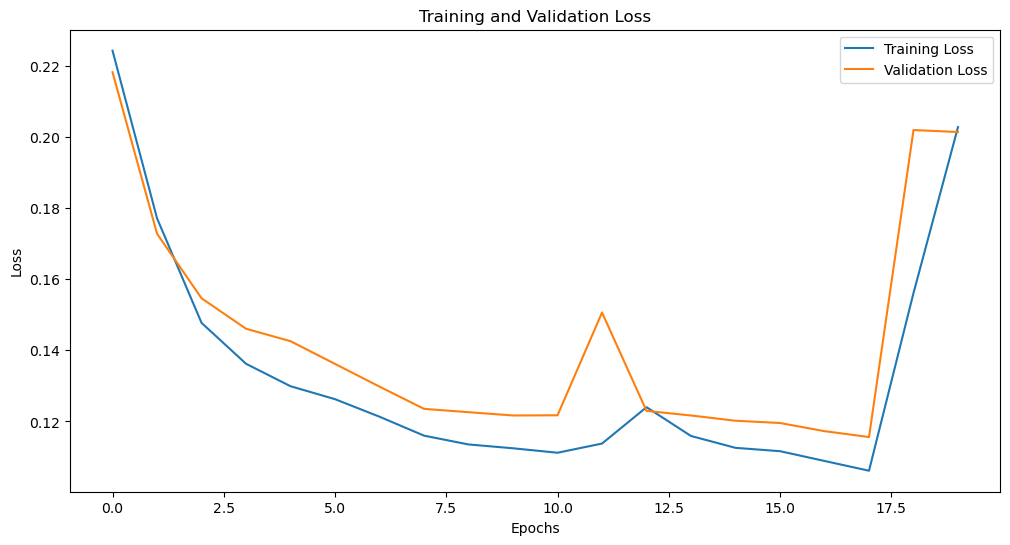

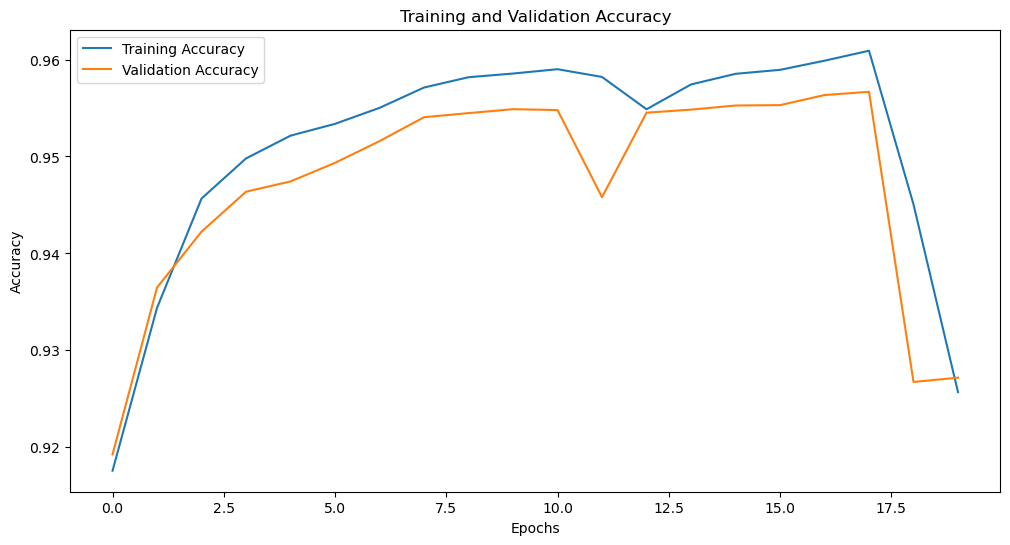

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

if 'accuracy' in history_dict:
    plt.figure(figsize=(12, 6))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


In [29]:
from sklearn.metrics import mean_squared_error

# Evaluate reconstruction performance
val_predictions = autoencoder.predict(x_val)
mse = mean_squared_error(
    x_val.flatten(),
    np.argmax(val_predictions, axis=-1).flatten()
)
print(f"Validation Reconstruction MSE: {mse}")


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 229s 183ms/step
Validation Reconstruction MSE: 1.1091904794520548


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


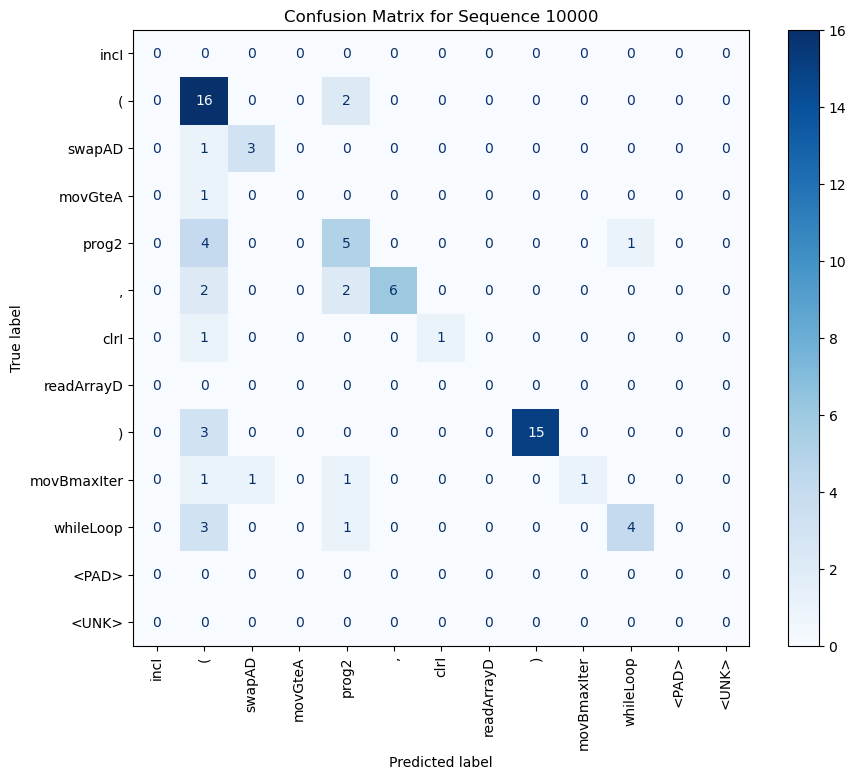

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


sample_index = 10000
original_sequence = x_val[sample_index]
reconstructed_sequence = autoencoder.predict(original_sequence[np.newaxis, :])[0]
reconstructed_sequence = np.argmax(reconstructed_sequence, axis=-1)

# Remove padding tokens (<PAD> = 0) from both sequences
non_pad_indices = original_sequence != vocab['<PAD>']
original_tokens = original_sequence[non_pad_indices]
reconstructed_tokens = reconstructed_sequence[non_pad_indices]

# Compute confusion matrix
cm = confusion_matrix(original_tokens, reconstructed_tokens, labels=list(vocab.values()))
labels = [token for token, idx in vocab.items()]  # Get labels in token order

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(include_values=True, cmap='Blues', xticks_rotation='vertical', ax=plt.gca())
plt.title(f'Confusion Matrix for Sequence {sample_index}')
plt.show()


In [34]:
sample_index = 0
original_sequence = x_val[sample_index]
reconstructed_sequence = autoencoder.predict(original_sequence[np.newaxis, :])[0]
reconstructed_sequence = np.argmax(reconstructed_sequence, axis=-1)

# Remove padding tokens (<PAD> = 0) for clarity
non_pad_indices = original_sequence != vocab['<PAD>']
original_tokens = original_sequence[non_pad_indices]
reconstructed_tokens = reconstructed_sequence[non_pad_indices]

# Map token IDs back to actual tokens
inverse_vocab = {idx: token for token, idx in vocab.items()}
original_tokens_mapped = [inverse_vocab[token] for token in original_tokens]
reconstructed_tokens_mapped = [inverse_vocab[token] for token in reconstructed_tokens]

# Compare and display results
matches = [o == r for o, r in zip(original_tokens_mapped, reconstructed_tokens_mapped)]
accuracy = sum(matches) / len(matches) * 100

print("Original Sequence:")
print(" ".join(original_tokens_mapped))

print("\nReconstructed Sequence:")
print(" ".join(reconstructed_tokens_mapped))

print(f"\nReconstruction Accuracy: {accuracy:.2f}%")
print("\nMismatched Tokens:")
for i, (o, r, match) in enumerate(zip(original_tokens_mapped, reconstructed_tokens_mapped, matches)):
    if not match:
        print(f"Position {i + 1}: Original='{o}' | Reconstructed='{r}'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Original Sequence:
prog2 ( whileLoop ( prog2 ( prog2 ( incI , movGteA ) , prog2 ( readArrayD , prog2 ( readArrayD , swapAD ) ) ) ) , prog2 ( readArrayD , swapAD ) )

Reconstructed Sequence:
prog2 ( whileLoop ( prog2 ( prog2 ( incI , movGteA ) , prog2 ( incI , prog2 ( readArrayD , movGteA ) ) ) ) , prog2 ( readArrayD , swapAD ) )

Reconstruction Accuracy: 94.12%

Mismatched Tokens:
Position 16: Original='readArrayD' | Reconstructed='incI'
Position 22: Original='swapAD' | Reconstructed='movGteA'


In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

correct_count = 0
incorrect_count = 0
results = []

for original_sequence in x_val[:1000]:
    reconstructed_sequence = autoencoder.predict(original_sequence[np.newaxis, :])[0]
    reconstructed_sequence = np.argmax(reconstructed_sequence, axis=-1)

    # Remove padding tokens (<PAD> = 0)
    non_pad_indices = original_sequence != vocab['<PAD>']
    original_tokens = original_sequence[non_pad_indices]
    reconstructed_tokens = reconstructed_sequence[non_pad_indices]

    if np.array_equal(original_tokens, reconstructed_tokens):
        results.append(0)  # 0 = Correct
        correct_count += 1
    else:
        results.append(1)  # 1 = Incorrect
        incorrect_count += 1

print(f"Total Sequences: {len(results)}")
print(f"Correctly Reconstructed: {correct_count}")
print(f"Incorrectly Reconstructed: {incorrect_count}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━